In [1]:
%matplotlib inline

import os, pathlib
from importlib import reload
import logging, warnings
from scipy.stats import pearsonr
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import pyaldata as pyal
from typing import Callable

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        from tools import lstm
        reload(lstm)
        import params
        reload(params)
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)

    # %run "fig2.ipynb"

    print('Done')

FIGPATH = params.figPath / 'figS7-topology'
if not os.path.exists(FIGPATH):
    os.makedirs(FIGPATH)

Done


### Get data

In [2]:
@utility.report
def get_full_monkey_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList_CO[monkey_defs.areas[2]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    for animal, session in full_list_MCx:
        path = root/animal/session

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))

    return full_list_MCx, allDFs_MCx



In [3]:
def get_time_averaged_data_array(data_list: list[pd.DataFrame], epoch: Callable =None , area: str ='M1', model: Callable =None, n_components:int = 10) -> np.ndarray:
    """
    Applies the `model` to the `data_list` and return a data matrix of the shape: sessions x targets x trials x time x modes
    with the minimum number of trials and timepoints shared across all the datasets/targets.
    
    Parameters
    ----------
    `data_list`: list of pd.dataFrame datasets from pyalData (could also be a single dataset)
    `epoch`: an epoch function of the type `pyal.generate_epoch_fun()`
    `area`: area, either: 'M1', or 'S1', or 'PMd', ...
    `model`: a model that implements `.fit()`, `.transform()` and `n_components`. By default: `PCA(10)`. If it's an integer: `PCA(integer)`.
    `n_components`: use `model`, this is for backward compatibility
    
    Returns
    -------
    `AllData`: np.ndarray

    Signature
    -------
    AllData = get_data_array(data_list, execution_epoch, area='M1', model=10)
    all_data = np.reshape(AllData, (-1,10))
    """
    if isinstance(data_list, pd.DataFrame):
        data_list = [data_list]
    
    existing_model = False
    if model is None:
        model = PCA(n_components=n_components, svd_solver='full')
    elif isinstance(model, int):
        model = PCA(n_components=model, svd_solver='full')
    else:
        existing_model = True
    
    field = f'{area}_rates'
    n_shared_trial = np.inf
    target_ids = np.unique(data_list[0].target_id)
    for df in data_list:
        for target in target_ids:
            df_ = pyal.select_trials(df, df.target_id== target)
            n_shared_trial = np.min((df_.shape[0], n_shared_trial))

    n_shared_trial = int(n_shared_trial)

    # finding the number of timepoints
    n_timepoints = 1

    # pre-allocating the data matrix
    AllData = np.empty((len(data_list), len(target_ids), n_shared_trial, n_timepoints, model.n_components))

    rng = np.random.default_rng(12345)
    for session, df in enumerate(data_list):
        df_ = pyal.restrict_to_interval(df, epoch_fun=epoch) if epoch is not None else df
        df_[field] = [np.mean(trial, axis = 0) for trial in df_[field]]
        rates = np.vstack(df_[field].values)
        if existing_model:
            rates_model = model
        else:
            rates_model = model.fit(rates)
        df_['_pca'] = [rates_model.transform(s.reshape(1,-1)) for s in df_[field]]
        # df_ = pyal.apply_dim_reduce_model(df_, rates_model, field, '_pca');

        for targetIdx,target in enumerate(target_ids):
            df__ = pyal.select_trials(df_, df_.target_id==target)
            all_id = df__.trial_id.to_numpy()
            # to guarantee shuffled ids
            while ((all_id_sh := rng.permutation(all_id)) == all_id).all():
                continue
            all_id = all_id_sh
            # select the right number of trials to each target
            df__ = pyal.select_trials(df__, lambda trial: trial.trial_id in all_id[:n_shared_trial])
            for trial, trial_rates in enumerate(df__._pca):
                AllData[session,targetIdx,trial, :, :] = trial_rates

    return AllData

### FigS10B: plot topology alignment example

In [4]:
@utility.report
def plot_monkey_topology_ex(azim = None, elev = None):
    defs = monkey_defs
    # raster_example = defs.raster_example
    raster_example = ('Chewie_CO_FF_2016-10-13.p', 'Mihili_CO_FF_2014-02-17.p')
    raster_example_df = []
    for session in raster_example:
        path = root/session.split('_')[0]/session
        df = defs.prep_general(dt.load_pyal_data(path))
        raster_example_df.append(df)
    
    df1, df2 = raster_example_df

    #get model from df1
    model = PCA(n_components=monkey_defs.n_components, svd_solver='full')
    field = f'{monkey_defs.areas[2]}_rates'
    df_ = pyal.restrict_to_interval(df, epoch_fun=monkey_defs.exec_epoch) 
    df_[field] = [np.mean(trial, axis = 0) for trial in df_[field]]
    rates = np.vstack(df_[field].values)
    rates_model = model.fit(rates)

    # time-averaged data
    AllData1_timeave = get_time_averaged_data_array(df1, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)[0]
    AllData2_timeave = get_time_averaged_data_array(df2, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)[0]
    AllData2_timeave_fitted = get_time_averaged_data_array(df2, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=rates_model)[0]

    _, min_trials, min_time,_ = np.min((AllData1_timeave.shape,AllData2_timeave.shape),axis=0)

    #unaligned
    data1_timeave = np.reshape(AllData1_timeave[:,:min_trials,:,:], (-1,monkey_defs.n_components))
    data2_timeave = np.reshape(AllData2_timeave[:,:min_trials,:,:], (-1,monkey_defs.n_components))
    # data2_timeave_fitted = np.reshape(AllData2_timeave_fitted[:,:min_trials,:,:], (-1,monkey_defs.n_components))

    #plotting unaligned
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot(projection = '3d')
    colors = utility.get_colors(8)

    for tar in range(8):
        ax.scatter(*data1_timeave[(tar)*min_trials:(tar+1)*min_trials, :3].T, edgecolors = colors[tar], marker = 'o', facecolors='none', alpha = 1)
        ax.scatter(*data2_timeave[(tar)*min_trials:(tar+1)*min_trials, :3].T, edgecolors = colors[tar], marker = 's', facecolors='none', alpha = 1)
        # ax.scatter(*data2_timeave_fitted[(tar)*min_trials:(tar+1)*min_trials, :3].T, edgecolors = colors[tar], marker = 's', facecolors='none', alpha = 1)
    
    ax.set_xlabel('Neural mode 1')
    ax.set_ylabel('Neural mode 2')
    ax.set_zlabel('Neural mode 3')

    if elev is not None:
        ax.elev = elev
    if azim is not None:
        ax.azim = azim
    plt.savefig(FIGPATH / 'topo_unaligned.pdf', format = 'pdf')

    #aligned
    A,B,_,U,V = dt.canoncorr(data1_timeave, data2_timeave, fullReturn = True)
    U1, _, Vh1 = linalg.svd(A, full_matrices=False, compute_uv=True, overwrite_a=False, check_finite=False)
    U2, _, Vh2 = linalg.svd(B, full_matrices=False, compute_uv=True, overwrite_a=False, check_finite=False)

    #plotting aligned
    fig=plt.figure(dpi=100)
    ax = fig.add_subplot(projection = '3d')
    colors = utility.get_colors(8)

    for tar in range(8):
        data1_ = data1_timeave[(tar)*min_trials:(tar+1)*min_trials]
        data1_ = data1_ @ U1 @ Vh1
        ax.scatter(*data1_[:,:3].T, edgecolors = colors[tar], marker = 'o', facecolors='none', alpha = 1)

        data2_ = data2_timeave[(tar)*min_trials:(tar+1)*min_trials]
        data2_ = data2_ @ U2 @ Vh2
        ax.scatter(*data2_[:,:3].T, edgecolors = colors[tar], marker = 's', facecolors='none', alpha = 1)
    
    ax.set_xlabel('Neural mode 1')
    ax.set_ylabel('Neural mode 2')
    ax.set_zlabel('Neural mode 3')

    if elev is not None:
        ax.elev = elev
    if azim is not None:
        ax.azim = azim
    
    plt.savefig(FIGPATH / 'topo_aligned_ex.pdf', format = 'pdf')


Executed: `plot_monkey_topology_ex` in 3.7s


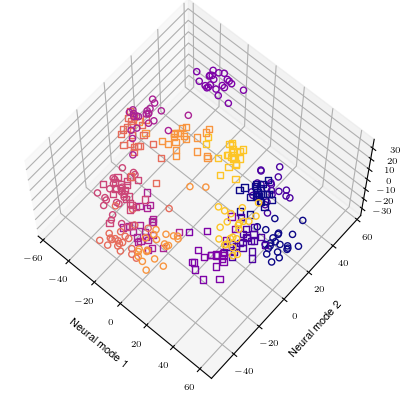

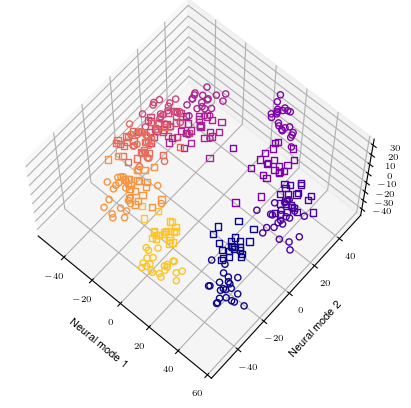

In [5]:
# %matplotlib widget
plot_monkey_topology_ex(azim = -49, elev = 65)

### Fig S10C&D: CCA based on aligning dynamics vs topology

In [6]:
@utility.report
def plot_monkey_topology(ax, full_list_MCx, allDFs_MCx):
    pairFileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            pairFileList1.append((I,J))

    side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
    side2df = [allDFs_MCx[j] for _,j in pairFileList1]

    # time-dependent data
    AllData1 = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    AllData2 = dt.get_data_array(side2df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)

    # time-averaged data
    AllData1_timeave = get_time_averaged_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    AllData2_timeave = get_time_averaged_data_array(side2df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)

    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)

    allCCs=[]
    topoCCs=[]
    for sessionData1, sessionData2, sessionData1_timeave, sessionData2_timeave in zip(AllData1, AllData2, AllData1_timeave, AllData2_timeave):

        #normal CCs
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,monkey_defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,monkey_defs.n_components))

        r = dt.canoncorr(data1, data2)
        allCCs.append(r)
     
        #topo CCs
        data1_timeave = np.reshape(sessionData1_timeave[:,:min_trials,:,:], (-1,monkey_defs.n_components))
        data2_timeave = np.reshape(sessionData2_timeave[:,:min_trials,:,:], (-1,monkey_defs.n_components))

        A,B,_,U,V = dt.canoncorr(data1_timeave, data2_timeave, fullReturn = True)
        
        #project normal data into CCs found by time averaged data
        n, p1 = data1.shape
        X = data1 - np.mean(data1,0);
        Y = data2 - np.mean(data2,0);
        U = X @ A / np.sqrt(n-1)
        V = Y @ B / np.sqrt(n-1)

        r = np.array([pearsonr(U_.flatten(), V_.flatten())[0] for U_,V_ in zip(U.T,V.T)])
        topoCCs.append(r)

    allCCs = np.array(allCCs).T
    topoCCs = np.array(topoCCs).T

    colors = utility.get_colors(6)
    for i, (x, y) in enumerate(zip(allCCs[:6,], topoCCs[:6,])):
        ax.scatter(x.flatten(),y.flatten(), c = colors[i], label = f'{i+1}')

    ymin, ymax = ax.get_ylim()
    ax.set_xlim((ymin,1))
    ax.set_ylim((ymin,1))
    ax.set_aspect(1)
    ax.plot([ymin, 1], [ymin,1], c = 'grey')
    ax.set_ylabel('Corr. aligning topology')
    ax.set_xlabel('Corr. aligning dynamics')
    ax.legend()
    
    return allCCs, topoCCs



Executed: `get_full_monkey_data` in 19.1s


/home/jcc319/multi_animal_alignment/tools/dataTools.py:492: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df_ = pyal.restrict_to_interval(df, epoch_fun=epoch) if epoch is not None else df
/home/jcc319/multi_animal_alignment/tools/dataTools.py:492: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df_ = pyal.restrict_to_interval(df, epoch_fun=epoch) if epoch is not None else df
/home/jcc319/multi_animal_alignment/tools/dataTools.py:492: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df_ = pyal.restrict_to_interval(df, epoch_fun=epoch) if epoch is not None else df
/home/jcc319/multi_animal_alignment/tools/dataTools.py:492: UserWarning: Dropping the trials with the following 

Executed: `plot_monkey_topology` in 337.0s


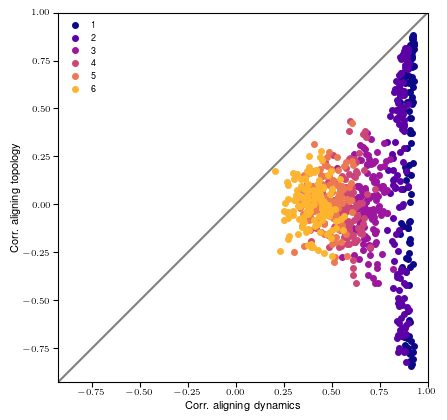

In [7]:
fig=plt.figure(dpi=100)
ax = fig.add_subplot()

full_list_MCx, allDFs_MCx = get_full_monkey_data()

allCCs, topoCCs = plot_monkey_topology(ax, full_list_MCx, allDFs_MCx)
plt.savefig(FIGPATH / 'topo_vs_dynamics.pdf', format = 'pdf')

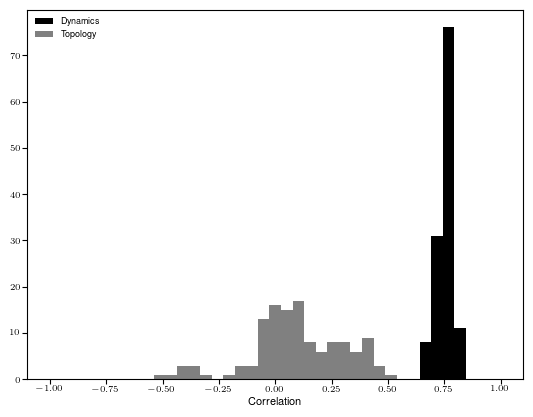

In [8]:
bins = np.linspace(-1, 1, 40)
fig=plt.figure(dpi=100)
ax = fig.add_subplot()
ax.hist(np.mean(allCCs[:4,],0).flatten(), bins = bins, label = 'Dynamics', color = 'k')
ax.hist(np.mean(topoCCs[:4,],0).flatten(), bins = bins, label = 'Topology', color = 'grey')
ax.legend()
ax.set_xlabel('Correlation')
plt.savefig(FIGPATH / 'topo_vs_dynamics_hist.pdf', format = 'pdf')